In [83]:
import numpy as np
from PIL import Image
import glob

In [84]:
file = './test/VanGogh.jpeg'
img = Image.open(file)

In [85]:
# 해상도 확인
print(np.array(Image.open(file),dtype=np.int32).shape)

(537, 425, 3)


In [86]:
# image 불러오기
file = './test/VanGogh2.jpeg'
img1 = Image.open(file)

In [87]:
# 해상도 확인
print(np.array(Image.open(file),dtype=np.int32).shape)

(537, 425, 3)


In [88]:
# vangogh의 유사 이미지 만들기
fileCount = 0
image_w = 425
image_h = 537

for angle in range(-30,30,1):
    img11 = img1.rotate(angle)
    img11.save('./Data/image_%03d.jpeg'%(fileCount),'JPEG')
    fileCount += 1

    # 반전 데이터 추가
    img111 = img11.transpose(Image.FLIP_LEFT_RIGHT)
    img111.save('./Data/image_%03d.jpeg'%(fileCount),'JPEG')
    fileCount += 1

    img21 = img.rotate(angle)
    img21.save('./Data/image_%03d.jpeg'%(fileCount),'JPEG')
    fileCount += 1

    # 반전 데이터 추가
    img211 = img21.transpose(Image.FLIP_LEFT_RIGHT)
    img211.save('./Data/image_%03d.jpeg'%(fileCount),'JPEG')
    fileCount += 1

### 사진들을 numpy 배열을 이용하여 Training Data 만들기

In [89]:
img_width_size = 425
img_height_size = 537
number_of_data = 240

In [90]:
train = np.zeros(number_of_data * img_width_size * img_height_size,dtype=np.int32).reshape(number_of_data,img_height_size,img_width_size)

In [91]:
# 현재 이미지를 gray로 변경하기
fileCount = 0

for file in sorted(glob.glob('./Data/*.jpeg')):
    img = Image.open(file)
    imgResize = img.convert('L')
    imgResize.save('./Data/gray/image_%03d.jpeg'%(fileCount),'JPEG')
    fileCount += 1

In [92]:
i = 0

# 이미지들 numpy 데이터로
for file in sorted(glob.glob('./Data/gray/*.jpeg')):
    img = Image.open(file)
    train[i] = np.array(img,dtype=np.int32)
    i += 1
    
train.shape

(240, 537, 425)

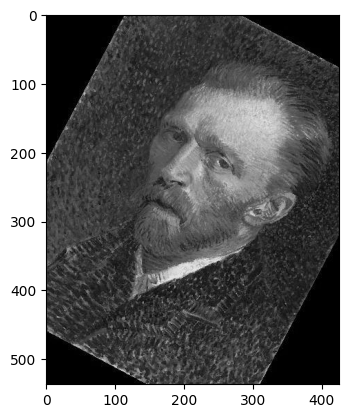

In [93]:
import matplotlib.pyplot as plt 

plt.imshow(train[10],cmap='gray')

In [94]:
# target 데이터
target = np.concatenate([np.zeros(120),np.ones(120)])

In [95]:
# 딥러닝 모델 만들기
from tensorflow import keras

In [96]:
train_scaled = train.reshape(-1,img_height_size,img_width_size,1) / 255.0

In [97]:
from sklearn.model_selection import train_test_split
train_scaled , val_scaled , train_target , val_target = \
    train_test_split(train_scaled,target,test_size=0.2)

In [101]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(
    32,
    kernel_size = 3,
    activation = 'relu',
    padding = 'same',
    input_shape = (537,425,1)
))

# pooling
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Conv2D(
    64,
    kernel_size = 3,
    activation = 'relu',
    padding = 'same'
))

# pooling
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(2,activation='softmax'))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('./Data/vangogh-model.h5')
# early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)

hist = model.fit(train_scaled,
                 train_target,
                 epochs=20,
                 validation_data = (val_scaled,val_target),
                 callbacks=[checkpoint_cb]
                 )

Epoch 1/20
6/6 [==============================] - 24s 4s/step - loss: 19.1649 - accuracy: 0.4740 - val_loss: 1.6831 - val_accuracy: 0.4583
Epoch 2/20
6/6 [==============================] - 20s 3s/step - loss: 2.0643 - accuracy: 0.5156 - val_loss: 0.7036 - val_accuracy: 0.4583
Epoch 3/20
6/6 [==============================] - 18s 3s/step - loss: 0.6754 - accuracy: 0.6198 - val_loss: 0.6937 - val_accuracy: 0.4375
Epoch 4/20
6/6 [==============================] - 21s 4s/step - loss: 0.6208 - accuracy: 0.6719 - val_loss: 0.6421 - val_accuracy: 0.6250
Epoch 5/20
6/6 [==============================] - 22s 4s/step - loss: 0.5302 - accuracy: 0.7812 - val_loss: 0.5094 - val_accuracy: 0.7708
Epoch 6/20
6/6 [==============================] - 22s 4s/step - loss: 0.3191 - accuracy: 0.9792 - val_loss: 0.5418 - val_accuracy: 0.7083
Epoch 7/20
6/6 [==============================] - 22s 4s/step - loss: 0.1782 - accuracy: 0.9896 - val_loss: 0.3583 - val_accuracy: 0.8333
Epoch 8/20
6/6 [=================

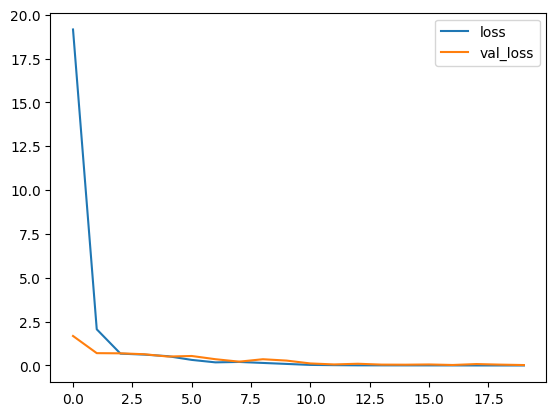

In [102]:
plt.plot(
    hist.history['loss'],
    label = 'loss'
)

plt.plot(
    hist.history['val_loss'],
    label = 'val_loss'
)

plt.legend()

plt.show()

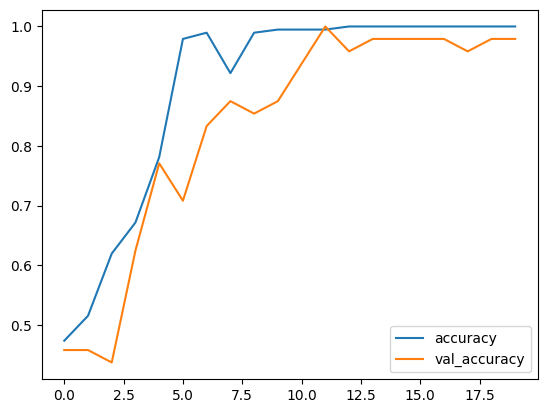

In [103]:
plt.plot(
    hist.history['accuracy'],
    label = 'accuracy'
)

plt.plot(
    hist.history['val_accuracy'],
    label = 'val_accuracy'
)

plt.legend()

plt.show()

In [104]:
model.evaluate(val_scaled,val_target)

2/2 [==============================] - 1s 245ms/step - loss: 0.0251 - accuracy: 0.9792


[0.025066105648875237, 0.9791666865348816]